# Malaria challenge trial calibration

### A history matching approach to calibrating an empirical model of malaria infection and immunity
### For iter0 we will cut down parameter space by using the distribution of malaria prevalence by season, age and density bins from a moderate high transmission setting in Sugungum, Garki, Nigeria

# Import block

In [22]:
from IPython.extensions import autoreload
%load_ext autoreload
%autoreload 2
import os, glob, re, sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import itertools
from calibtool.analyzers.Helpers import \
    convert_to_counts, age_from_birth_cohort, season_from_time, aggregate_on_index

# from wand.image import Image as WImage
from IPython.display import IFrame, display

from pyDOE import lhs
from history_matching import HistoryMatching, HistoryMatchingCut, quick_read, Basis

sns.set(font_scale=2)
sns.set_style("white")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def fix_glob(pth):
    return re.sub('([\[\]])','[\\1]', pth)

# Configure parameters and data for history matching

In [3]:
cut_name = f'Density_by_age_and_season'

# iteration = int(re.search(r'iter(\d+)', os.getcwd())) # Index of the current iteration
iteration = 0 
#list of exp_ids/folders that correspond to exp_ids from which our emulation will draw
exp_ids = ['9be99541-56ff-e911-a2c3-c4346bcb1551'] # TODO: only uses first for now, should loop
basedir = 'C:\git\Malaria-Uganda-PRISM'
datafile = os.path.join('..','reference data', 'Garki_df.csv')

In [4]:
# The implausibility threshold determines how willing we are to retain regions
# of parameter space that are inconsistent with the underlying data. A higher
# threshold is more risk averse in that potentially good regions are less likely
# to be rejected, however it will take more iterations/simulations to achieve results.
implausibility_threshold = 3
training_fraction = 0.75 # Fraction of simulations to use as training
discrepancy_std = 0.0 # Accounts for uncertainty w.r.t model structure
n_samples_to_generate_for_next_iter = 1000 # Number of simulations to conduct on this iteration

In [5]:
# Here we define the parameter names and ranges
params_file = os.path.join('..','Params.xlsx')
param_info = quick_read(params_file, 'Params').set_index('Name')
param_names = param_info.index.tolist()

params = param_info.index.values
n_params = param_info.shape[0] # We'll use this one place later
display(param_info)

Reading Params from ..\Params_bbe09b53b075d0c7ce0bb97263972a47.hd5


,Min,Max,MapTo
Name,,,
Biological_Age_Immune_Coefficient_PPP,0,100,Biological_Age_Immune_Coefficient_PPP
Biological_Age_Immune_Coefficient_TM,-5,5,Biological_Age_Immune_Coefficient_TM
Cumulative_Exposure_Immune_Coefficient_PPP,0,100,Cumulative_Exposure_Immune_Coefficient_PPP
Cumulative_Exposure_Immune_Coefficient_TM,-5,5,Cumulative_Exposure_Immune_Coefficient_TM
Scale_Factor_Age_a,0,100,Scale_Factor_Age_a
Scale_Factor_Age_b,0,100,Scale_Factor_Age_b
Scale_Factor_Cum_Exp_shape,0,50,Scale_Factor_Cum_Exp_shape
Concurrent_Infections_a,0,100,Concurrent_Infections_a
Concurrent_Infections_b,0,100,Concurrent_Infections_b


## Read in Sim Results

In [7]:
all_samples = []
all_results = []
for exp_id in exp_ids:
    
    print('-'*80, '\nExperiment:', exp_id)
    sim_results_fn = os.path.join(exp_id, 'analyzer_results.csv')
    print(sim_results_fn)
    sr = pd.read_csv(sim_results_fn, skipinitialspace=True)
    sr['Sample_Id'] = sr['sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    sr.rename(columns = {'sim_id': 'Sim_Id','value':'Result'}, inplace=True)
    all_results.append( sr )
    #read in tags making a samples.xlsx file 
    s = pd.read_excel(os.path.join(exp_id, 'Samples.xlsx'))
    # s.drop('Sim_Id', axis=1, inplace=True)
    s['Sample_Id'] = s['Sample'].apply(lambda x: '%s.%06d' % (exp_id, x))
    all_samples.append( s )

#.rename(columns={'level_1': 'Year', 0: 'Cases'}) \
all_results = pd.concat(all_results) \
    .set_index(['Sample_Id', 'Sim_Id']) \
    [['Result']] \
    .sort_index()

samples = pd.concat(all_samples).set_index('Sample_Id').sort_index() # Bad because sample will be repeated across exp_id!
                       
samples.to_csv('Samples.csv')
all_results.to_csv('Results.csv')
results = all_results['Result']

results = all_results \
    .groupby(['Sample_Id', 'Sim_Id']) \
    .mean()

    
results.rename(columns={'Result':'Sim_Result'}, inplace=True)

display(results.head())

-------------------------------------------------------------------------------- 
Experiment: 9be99541-56ff-e911-a2c3-c4346bcb1551
9be99541-56ff-e911-a2c3-c4346bcb1551\analyzer_results.csv


,,Sim_Result
Sample_Id,Sim_Id,
9be99541-56ff-e911-a2c3-c4346bcb1551.000000,82ff0748-56ff-e911-a2c3-c4346bcb1551,0.348831
9be99541-56ff-e911-a2c3-c4346bcb1551.000001,83ff0748-56ff-e911-a2c3-c4346bcb1551,0.643822
9be99541-56ff-e911-a2c3-c4346bcb1551.000002,84ff0748-56ff-e911-a2c3-c4346bcb1551,0.411629
9be99541-56ff-e911-a2c3-c4346bcb1551.000003,85ff0748-56ff-e911-a2c3-c4346bcb1551,0.365076
9be99541-56ff-e911-a2c3-c4346bcb1551.000004,86ff0748-56ff-e911-a2c3-c4346bcb1551,0.353445


In [23]:
ref_data_path = os.path.join('..','reference data','Garki_df.csv')
df = pd.read_csv(ref_data_path)

self = pd.DataFrame()
self.metadata =  {
        'density_bins': [0, 50, 200, 500, np.inf],  # (, 0] (0, 50] ... (50000, ]
        'density_bin_edges':['0', '50', '200', '500'],
        'age_bins': [0, 1, 4, 8, 18, 28, 43, np.inf],  # (, 5] (5, 15] (15, ],
        'age_bin_labels':['<1', '1-4', '4-8', '8-18', '18-28', '28-43', '>43'],
        'seasons': ['DC2', 'DH2', 'W2'],
        'seasons_by_month': {
            'Apr': 'DH2',
            'June/Aug': 'W2',
            'Dec/Jan': 'DC2'
        },
        'village': 'Sugungum'
    }

df = df.loc[df['Village']==self.metadata['village']]
pfprBinsDensity = self.metadata['density_bins']
uL_per_field = 0.5 / 200.0  # from Garki PDF - page 111 - 0.5 uL per 200 views
pfprBins = 1 - np.exp(-np.asarray(pfprBinsDensity) * uL_per_field)
seasons = self.metadata['seasons']
pfprdict = dict(zip(pfprBins, pfprBinsDensity))

bins = OrderedDict([
    ('Season', self.metadata['seasons']),
    ('Age Bin', self.metadata['age_bins']),
    ('PfPR Bin', pfprBins)
])
bin_tuples = list(itertools.product(*bins.values()))
index = pd.MultiIndex.from_tuples(bin_tuples, names=bins.keys())

df = df.loc[df['Seasons'].isin(seasons)]
df = df.rename(columns={'Seasons': 'Season', 'Age': 'Age Bin'})

df2 = grouped_df(df, pfprdict, index, 'Parasitemia', 'Gametocytemia')
df3 = grouped_df(df, pfprdict, index, 'Gametocytemia', 'Parasitemia')
dfJoined = df2.join(df3).fillna(0)
dfJoined = pd.concat([dfJoined['Gametocytemia'], dfJoined['Parasitemia']])
dfJoined.name = 'Counts'
dftemp = dfJoined.reset_index()
dftemp['Channel'] = 'PfPR by Gametocytemia and Age Bin'
dftemp.loc[len(dftemp) / 2:, 'Channel'] = 'PfPR by Parasitemia and Age Bin'
dftemp = dftemp.rename(columns={'Seasons': 'Season', 'PfPR Bins': 'PfPR Bin', 'Age Bins': 'Age Bin'})
dftemp = dftemp.set_index(['Channel', 'Season', 'Age Bin', 'PfPR Bin'])

# how to set the cwd
ref_data =dftemp
ref_data['bin_pop'] = ref_data.groupby(by=['Channel', 'Season', 'Age Bin'])['Counts'].sum()
ref_data['proportion'] = ref_data['Counts'] / ref_data['bin_pop']
ref_data.reset_index(inplace=True)
a = ref_data[(ref_data['PfPR Bin'] != 0) &(ref_data['Channel'] == 'PfPR by Parasitemia and Age Bin')]

mean =  np.nanmean([sum(x.proportion) for i,x in a.groupby(by= ['Season', 'Age Bin'])])

desired_result = mean
desired_result_std = np.nan

print('Before logit, desired result is %.3f [%.3f, %.3f]: ' % (desired_result, desired_result-2*desired_result_std, desired_result+2*desired_result_std))


Before logit, desired result is 0.570 [nan, nan]: 


c:\venv\malaria-ug-icemr\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()


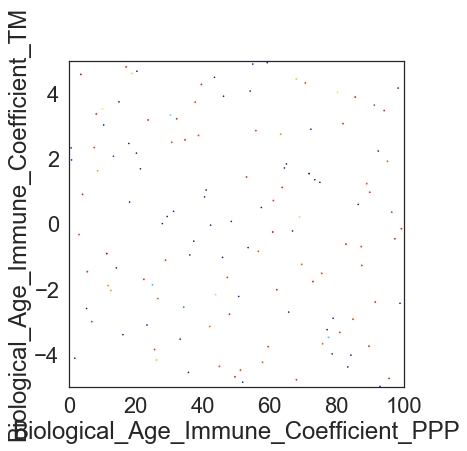

In [24]:
z = pd.merge(samples, results, on='Sample_Id') # Return to Sample_Id

#sub in variables here, can be list of tuples
xyvars = [('Biological_Age_Immune_Coefficient_PPP',	'Biological_Age_Immune_Coefficient_TM'
)]
for (xvar, yvar) in xyvars:
    fig = plt.figure(figsize=(6,6))
    plt.scatter(z[xvar], z[yvar], c=100*z['Sim_Result'], s=1*z['Sim_Result'], cmap='jet')
    plt.xlabel(xvar); plt.ylabel(yvar)
    plt.xlim([param_info.loc[xvar, 'Min'], param_info.loc[xvar, 'Max']])
    plt.ylim([param_info.loc[yvar, 'Min'], param_info.loc[yvar, 'Max']])
    # TODO: Show as surface and plot desired result as isocline
plt.show()

In [25]:
# Finally we get to do some History Matching!
# Begin by creating an instance of the HistoryMatching class
ext = 'svg' # Filetype for figures produced by history matching
hm = HistoryMatching(
    cut_name = cut_name,
    param_info = param_info,
    inputs = samples,
    results = results.squeeze(),
    desired_result = desired_result,
    desired_result_var = desired_result_std**2,
    iteration = iteration,
    implausibility_threshold = implausibility_threshold,
    discrepancy_var = discrepancy_std**2,
    training_fraction = training_fraction,
    fig_type = ext
)
hm.save() # Save to disk

Welcome to IDM History Matching!
Found 128 unique parameter configurations, each of which is repeated 1 time(s).
--> Training with 96 unique parameter configurations ( 96  simulations including replicates)
--> Testing  with 32  unique parameter configurations ( 32 simulations including replicates)


Regularize:  0  of  15
Regularize:  1  of  15
Regularize:  2  of  15
Regularize:  3  of  15
Regularize:  4  of  15
Regularize:  5  of  15
Regularize:  6  of  15
Regularize:  7  of  15
Regularize:  8  of  15
Regularize:  9  of  15
Regularize:  10  of  15
Regularize:  11  of  15
Regularize:  12  of  15
Regularize:  13  of  15
Regularize:  14  of  15


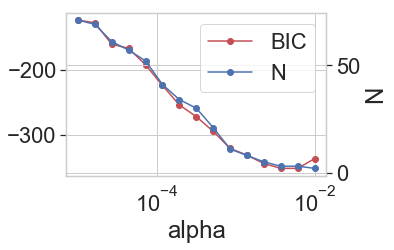

What would you like to use for the GLM regularization parameter, alpha_glm = 1e-4
User selected alpha = 0.000100
Non-Zero: 46 of 78
Regularization for GLM selected:
  * Intercept
 * Cumulative_Exposure_Immune_Coefficient_PPP
 * Cumulative_Exposure_Immune_Coefficient_TM
 * Scale_Factor_Age_a
 * Scale_Factor_Age_b
 * Scale_Factor_Cum_Exp_shape
 * Concurrent_Infections_a
 * Concurrent_Infections_b
 * Concurrent_Infections_c
 * Biological_Age_Immune_Coefficient_PPP ** 2
 * Biological_Age_Immune_Coefficient_TM ** 2
 * Cumulative_Exposure_Immune_Coefficient_PPP ** 2
 * Cumulative_Exposure_Immune_Coefficient_TM ** 2
 * Scale_Factor_Age_b ** 2
 * Scale_Factor_Cum_Exp_shape ** 2
 * Concurrent_Infections_a ** 2
 * Concurrent_Infections_b ** 2
 * Wave_Vs_Infection_Relative_Weight ** 2
 * Biological_Age_Immune_Coefficient_PPP * Biological_Age_Immune_Coefficient_TM
 * Biological_Age_Immune_Coefficient_PPP * Cumulative_Exposure_Immune_Coefficient_TM
 * Biological_Age_Immune_Coefficient_PPP * Scale_F

In [26]:
try:
    existing_basis = True
    need_basis = True
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json')) as data_file:
        config = json.load( data_file )
        basis_glm = Basis.deserialize(config['Basis'])
        fitted_values = pd.read_json(config['Fitted_Values'], orient='split').set_index(['Sample_Id', 'Sim_Id']).squeeze()
except:
    existing_basis = False
    
if existing_basis:
    print('Found existing GLM basis with the following terms:')
    display(basis_glm.model_terms)
    reply = input('Would you like to use this basis? [Y]/n: ')
    
    if reply.lower() != 'n':
        need_basis = False
    
if need_basis:
    basis_glm = Basis.polynomial_basis(params=param_names, intercept = True, first_order=True, second_order=True, third_order=False, param_info=param_info)

    basis_glm.plot_regularize(samples, results, alpha = np.logspace(-5, -2, 15), scaleX=True)
    alpha_glm = float(input('What would you like to use for the GLM regularization parameter, alpha_glm = '))
#     alpha_glm = 1e-1
    
    fitted_values = basis_glm.regularize(samples, results, alpha = alpha_glm, scaleX=True)
    print('Regularization for GLM selected:\n', ' *','\n * '.join(basis_glm.get_terms()))
    with open(os.path.join('Cuts', cut_name, 'basis_glm.json'), 'w') as fout:
        json.dump( {
            'Basis': basis_glm.serialize(),
            'Fitted_Values': fitted_values.reset_index().to_json(orient='split')
        }, fout, indent=4)

In [29]:
# Now fit the glm and plot

### GLM ###############################################################
print("="*80, "\nGeneralized Linear Modeling\n", "="*80)
#######################################################################
f = hm.glm(
    basis = basis_glm,
    family = 'Poisson',
    force_optimize_glm = True,
    glm_fit_maxiter = 1000,
    plot = True, #force_optimize_glm,
    plot_data = True
)

Generalized Linear Modeling
Plotting


In [30]:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [31]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.glmdir, "GLM Predicted vs Actual*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

..\iter0\Cuts\Density_by_age_and_season\GLM\GLM Predicted vs Actual.svg


In [32]:
basis_gpr = Basis.polynomial_basis(
    params =  ['Scale_Factor_Age_a', 'Scale_Factor_Age_b','Biological_Age_Immune_Coefficient_PPP',
'Biological_Age_Immune_Coefficient_TM',
'Cumulative_Exposure_Immune_Coefficient_PPP',
'Cumulative_Exposure_Immune_Coefficient_TM'
              ],
#     params = param_info.index.values, #
    intercept = False, 
    first_order = True, 
    param_info=param_info)

In [33]:

### GPR ###############################################################
print("="*80, "\nGaussian Process Regression\n", "="*80)
#######################################################################
hm.gpr(
    basis = basis_gpr,
    force_optimize_gpr = True,

    sigma2_f_guess = 0.6,
    sigma2_f_bounds = (0.1, 1000),
    sigma2_n_guess =  2.0,
    sigma2_n_bounds = (0.01, 100),

    #lengthscale_guess = [0.09844299, 0.1256657, 0.0976875, 0.09889085, 0.1051974, 0.0950809, 0.10032171, 0.10599185, 0.10627393, 0.09950996, 0.09445544, 0.10285915, 0.10007409, 0.09847433, 0.08963389, 0.10205652, 0.09360044, 0.1024141, 0.09786228, 0.10247492, 0.09852253, 0.09632744, 0.09997534, 0.10767302, 0.10095249, 0.09941825, 0.10214923, 0.10221497, 0.09734157, 0.09093285, 0.10780673, 0.09881377, 0.10597152],
    lengthscale_guess = 0.25,
    lengthscale_bounds = (0.01, 100),

    optimize_sigma2_n = True,
    log_transform = False,

    verbose = True,
    optimizer_options = {
        'eps': 5e-3,
        'disp': True,
        'maxiter': 15000,
        'ftol': 2 * np.finfo(float).eps,
        'gtol': 2 * np.finfo(float).eps,
    },
    plot = True, #force_optimize_gpr,
    plot_data = False
)

Gaussian Process Regression
Fitting the GPR

	LL: 153.38319548237956 
	Theta: [0.6  2.   0.25 0.25 0.25 0.25 0.25 0.25] 
	Deriv: [ 7.89637166  9.5334799  -1.00383381 -0.60608358 -1.07188796 -1.56709665
 -2.17329407  0.9688334 ]

	LL: 1604.6693254363167 
	Theta: [0.1        0.01       1.25383381 0.85608358 1.32188796 1.81709665
 2.42329407 0.01      ] 
	Deriv: [-2.59499044e+03 -1.39273894e+05  1.87028026e+01  2.12965632e+02
  1.06666292e+02  2.58834527e+01  4.80835876e+01  3.08760044e+04]

	LL: 142.7936929028168 
	Theta: [0.43147196 1.32925842 0.58834828 0.45428415 0.61128635 0.77819944
 0.98252196 0.16910654] 
	Deriv: [ 3.91156716  8.10447851 -1.35235946 -1.83902537 -1.11964504 -0.88241521
 -0.60826766 31.0217391 ]

	LL: 130.37038134344883 
	Theta: [0.26573598 0.66962921 0.92109104 0.65518386 0.96658715 1.29764805
 1.70290802 0.08955327] 
	Deriv: [-21.70745453  -3.32287769  -1.8400245   -2.98575202  -1.26378096
  -0.71187246  -0.3643211  226.35289134]

	LL: 138.74941217978488 
	Theta: 


	LL: 107.06109717367372 
	Theta: [1.97041744e+00 4.94613493e-01 8.50739880e+01 5.14918627e+01
 9.08644253e+01 9.47826095e+01 1.00000000e+02 1.82775134e-02] 
	Deriv: [ 2.18561856e-01  2.89109155e-01  2.48544279e-05 -6.55927572e-03
 -2.56509622e-03  1.78533926e-05 -2.41303891e-04 -4.17315775e+00]

	LL: 107.04686365811685 
	Theta: [2.15356209e+00 4.95683612e-01 9.39775380e+01 5.68713384e+01
 1.00000000e+02 8.69479119e+01 1.00000000e+02 1.83520626e-02] 
	Deriv: [ 2.36018942e-01  5.21197867e-01  7.28482822e-07 -5.87583664e-03
 -2.32109361e-03  8.02989052e-06 -2.76059789e-04 -1.55705344e+01]

	LL: 107.04413725144829 
	Theta: [2.15371817e+00 4.94621395e-01 9.39789381e+01 5.68721803e+01
 1.00000000e+02 8.66519184e+01 1.00000000e+02 1.85297602e-02] 
	Deriv: [ 2.24083999e-01  3.46000402e-01  1.27306899e-06 -5.90300320e-03
 -2.32679619e-03  1.25444842e-06 -2.69088180e-04 -1.02439822e+01]

	LL: 107.04204615725956 
	Theta: [2.15362279e+00 4.92641088e-01 9.39764171e+01 5.68706565e+01
 1.00000000e+0


	LL: 106.84875447039433 
	Theta: [8.48494914e-01 4.78762005e-01 6.25100268e+01 3.78765183e+01
 1.00000000e+02 3.92033215e+00 9.99999998e+01 1.38908895e-02] 
	Deriv: [ 9.28100717e-02 -6.78343212e-01 -4.91617364e-04 -5.07924561e-03
 -1.00969779e-03 -2.18952586e-03  4.44556746e-05  3.00250483e-01]

	LL: 106.84735709439497 
	Theta: [8.50776147e-01 4.82111317e-01 6.25692538e+01 3.79122636e+01
 1.00000000e+02 4.20207520e+00 9.99999999e+01 1.39026538e-02] 
	Deriv: [ 7.67274547e-02 -7.02605975e-02 -4.67621768e-04 -5.09029502e-03
 -1.00250427e-03  1.02712814e-03  3.52456007e-05  8.58810658e-01]

	LL: 106.86830994901308 
	Theta: [8.25569597e-01 4.86574745e-01 6.19838943e+01 3.75589567e+01
 1.00000000e+02 2.85087696e+00 9.99999997e+01 1.36033513e-02] 
	Deriv: [ 2.19220155e-01  1.08491814e+00 -6.10618745e-04 -4.74424628e-03
 -9.59080364e-04 -4.04788633e-02  4.79989168e-05 -7.26520999e+00]

	LL: 106.84729779225859 
	Theta: [8.49149596e-01 4.82399337e-01 6.25314812e+01 3.78894651e+01
 1.00000000e+0


	LL: 106.70515201344713 
	Theta: [9.59190304e-01 4.81383712e-01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 4.66310416e+00 9.99995241e+01 1.45429629e-02] 
	Deriv: [ 6.70617844e-04  5.72804782e-03 -2.29941117e-04 -9.27082130e-04
 -1.13921375e-03  7.88417477e-05  4.69910446e-05 -7.93478700e-01]

	LL: 106.70513738090357 
	Theta: [9.63404374e-01 4.81389571e-01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 4.66953308e+00 9.99995125e+01 1.45801482e-02] 
	Deriv: [ 4.74954724e-04  1.12402434e-02 -2.31339847e-04 -9.31745732e-04
 -1.14434433e-03 -3.62404097e-05  4.76039238e-05 -1.55562035e-01]

	LL: 106.70513488651034 
	Theta: [9.64187057e-01 4.81344040e-01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 4.67443320e+00 9.99995082e+01 1.45878590e-02] 
	Deriv: [ 1.31118759e-04  2.28714646e-03 -2.31435761e-04 -9.32799731e-04
 -1.14544434e-03 -1.02740456e-05  4.77524272e-05 -1.01291159e-02]

	LL: 106.70513361102586 
	Theta: [9.64130953e-01 4.81333853e-01 1.00000000e+02 1.00000000e+02
 1.00000000e+0


	LL: 106.70513411914789 
	Theta: [9.64129334e-01 4.81333210e-01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 4.67498608e+00 9.99995080e+01 1.45878691e-02] 
	Deriv: [-9.24553358e-06 -1.87406992e-05 -2.31386126e-04 -9.32786478e-04
 -1.14541163e-03  1.97279837e-07  4.77622645e-05 -3.77502602e-05]

	LL: 106.70513216434503 
	Theta: [9.64129334e-01 4.81333209e-01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 4.67498608e+00 9.99995080e+01 1.45878800e-02] 
	Deriv: [ 4.13415919e-07 -9.61885571e-06 -2.31386551e-04 -9.32786991e-04
 -1.14541157e-03  5.23125175e-08  4.77630716e-05  4.21006250e-04]

	LL: 106.70513216434503 
	Theta: [9.64129334e-01 4.81333209e-01 1.00000000e+02 1.00000000e+02
 1.00000000e+02 4.67498608e+00 9.99995080e+01 1.45878800e-02] 
	Deriv: [ 4.13415919e-07 -9.61885571e-06 -2.31386551e-04 -9.32786991e-04
 -1.14541157e-03  5.23125175e-08  4.77630716e-05  4.18906496e-04]

	LL: 106.70513742232401 
	Theta: [9.64129334e-01 4.81333210e-01 1.00000000e+02 1.00000000e+02
 1.00000000e+0

In [34]:
pi = param_info.loc[basis_gpr.param_dict.keys()].reset_index()
pi['Lengthscale'] = hm.gpr_model.theta[2:]
print(pi[['Name', 'Lengthscale']].sort_values('Lengthscale'))

                                         Name  Lengthscale
5   Cumulative_Exposure_Immune_Coefficient_TM     0.014588
3        Biological_Age_Immune_Coefficient_TM     4.674986
4  Cumulative_Exposure_Immune_Coefficient_PPP    99.999508
0                          Scale_Factor_Age_a   100.000000
1                          Scale_Factor_Age_b   100.000000
2       Biological_Age_Immune_Coefficient_PPP   100.000000


In [35]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.gprdir, "PairwiseResults", "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

In [36]:
### Implausibility ############################################################
print("="*80, "\nImplausibility\n", "="*80)
###############################################################################
hm.calc_and_plot_implausibility(
    plot = True,
    do_plot_data = False,
    plot_data_highlight = pd.DataFrame() #hm.test_data.loc['prime.000049']
) 
    #plot_data_highlight=pd.DataFrame() # plot_data_highlight=hm.training_data.loc['prime.000049']

hm.training_data.to_excel(os.path.join('Cuts', cut_name, 'train_data.xlsx'))
hm.test_data.to_excel(os.path.join('Cuts', cut_name, 'test_data.xlsx'))

print('Good')

Implausibility
Good


In [37]:
# Results get saved to disk, so load and display:
for file in glob.glob(fix_glob(os.path.join(hm.combineddir, "*.%s"%ext))):
    img = IFrame(file, width=800, height=600)
    print(file)
    display(img)

..\iter0\Cuts\Density_by_age_and_season\Implausibility\implausibility.svg


In [38]:
ar = all_results.reset_index()

data = ar.loc[ar['AgeBin']==age_bin[0]].groupby(['Sample_Id','AgeBin'])['Result'].mean().reset_index().set_index('Sample_Id')

train = hm.training_data
train['Train'] = True
test = hm.test_data
test['Train'] = False
train_test = pd.concat([train, test])

fig, ax = plt.subplots(figsize=(16,10))

# Reference
#ref_by_year = reference_data[['Prevalence']].reset_index()

ref_by_year = ref_df.loc[ref_df['Age bin'] == int(age_bin[0][:2])] \
    .groupby('Age bin') \
    .mean() \
    .reset_index()
print(ref_by_year)
print(data)
sns.lineplot(data=ref_by_year, x='Age bin', y='Mean', color='k', marker='o', alpha=1, lw=2, zorder=1);

# Sims
tmp = data.merge(train_test[['Sample_Orig', 'Implausible', 'Train']], left_on='Sample_Id', right_on='Sample_Orig')
print(tmp.head())
sns.lineplot(data=tmp, x='AgeBin', y='Result', hue='Implausible', style='Train', 
             units='Sample_Orig', estimator=None, alpha=0.5, lw=0.5,
             ax=ax, zorder=-1)
ax.set_xlabel('AgeBin');
ax.set_ylabel('Duration');
ax.set_xticks(ref_by_year['Age bin'].unique());

KeyError: 'AgeBin'